# Parametric shape optimization with differentiable FEM simulation


## Setup

In [ ]:
# Install additional requirements for this notebook
%pip install -r requirements_os.txt -q --isolated

In [ ]:
import tesseract_core

tesseract_core.build_tesseract("sdf_fd", "latest")
tesseract_core.build_tesseract("bars_3d", "latest")
tesseract_core.build_tesseract("meshing_tess", "latest")
tesseract_core.build_tesseract("meshing_tess", "latest")
print("Tesseract built successfully.")

## Design Space Tesseract

In [3]:
import imageio
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from tesseract_jax import apply_tesseract
from utils import plot_grid, plot_mesh, stop_grads_int

from tesseract_core import Tesseract

In [ ]:
# Due to a limiation in higher order Tesseracts
# we have to serve this Tesseract from the runtime
design_tess = Tesseract.from_tesseract_api("sdf_fd/tesseract_api.py")

hex_tess = Tesseract.from_image("hex_mesh")
hex_tess.serve()

fem_tess = Tesseract.from_image("jax_fem")
fem_tess.serve()

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [5]:
n_chains = 3
n_edges_per_chain = 3
bar_radius = 0.7

Lx, Ly, Lz = 20.0, 10.0, 10.0
Nx, Ny, Nz = 128, 64, 64

# Initialize chain parameter array
initial_params = jnp.zeros((n_chains, n_edges_per_chain + 1, 3), dtype=jnp.float32)

for chain in range(n_chains):
    initial_params = initial_params.at[chain, :, 0].set(
        jnp.linspace(-Lx / 2, Lx / 2, n_edges_per_chain + 1)
    )

    initial_params = initial_params.at[chain, :, 1].set(
        (chain + 1) / (n_chains + 1) * Lz - Lz / 2
    )


initial_params = initial_params.flatten()

normalization_factors = jnp.ones_like(initial_params, dtype=jnp.float32) * 0.1
initial_params = initial_params * normalization_factors
normalization_bias = jnp.zeros_like(initial_params, dtype=jnp.float32)


design_inputs = {
    "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
    "static_parameters": [n_chains, n_edges_per_chain + 1],
    "string_parameters": [],
    "mesh_tesseract": {"type": "image", "ref": "bars_3d"},
    "grid_size": [Lx, Ly, Lz],
    "grid_elements": [Nx, Ny, Nz],
    "epsilon": 0.01,  # epsilon, only used for FD of the jacobian
    "grid_center": [0.0, 0.0, 0.0],
    "max_points": 2000,
    "max_faces": 4000,
    "normalization_factors": normalization_factors,
    "normalization_bias": normalization_bias,
    "normalize_jacobian": False,
    "precompute_jacobian": True,
    "sdf_backend": "pyvista",
}

In [6]:
design_out = design_tess.apply(
    {
        "differentiable_parameters": initial_params,
        **design_inputs,
    }
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

print("SDF shape:", sdf.shape)

Number of vertices: 360
Number of faces: 708
SDF shape: (128, 64, 64)


Using matplotlib and a helper function we can visualize the generated triangular mesh.

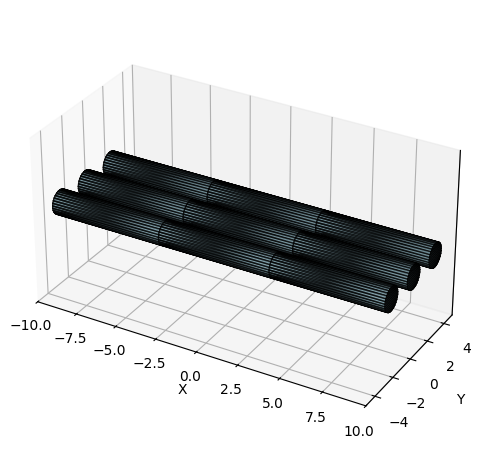

In [7]:
plot_mesh(mesh, [Lx, Ly, Lz], figsize=(8, 5))

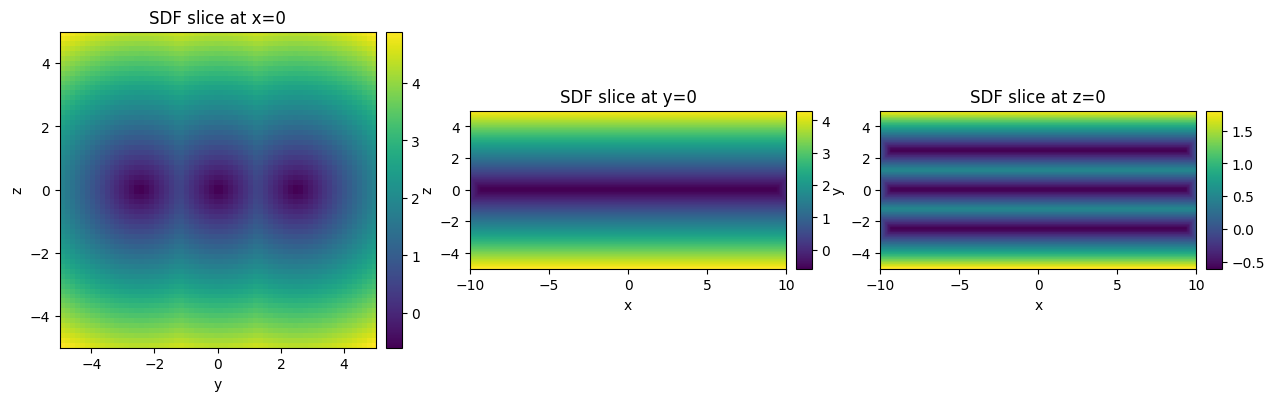

In [8]:
plot_grid(sdf, Lx, Ly, Lz, Nx, Ny, Nz)

To generate a smooth density field from the SDF field, we define a specific function that uses a sigmoid internally.

rho min: 5.256046708979056e-09, rho max: 0.9493274092674255


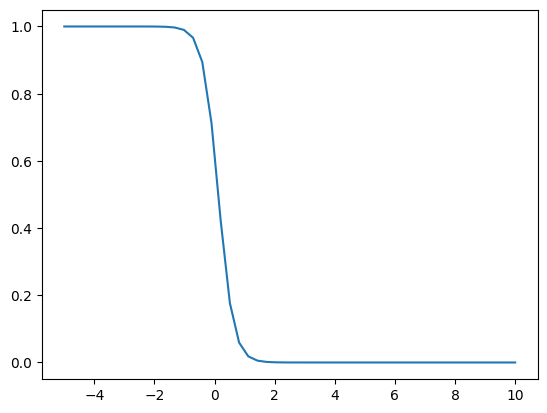

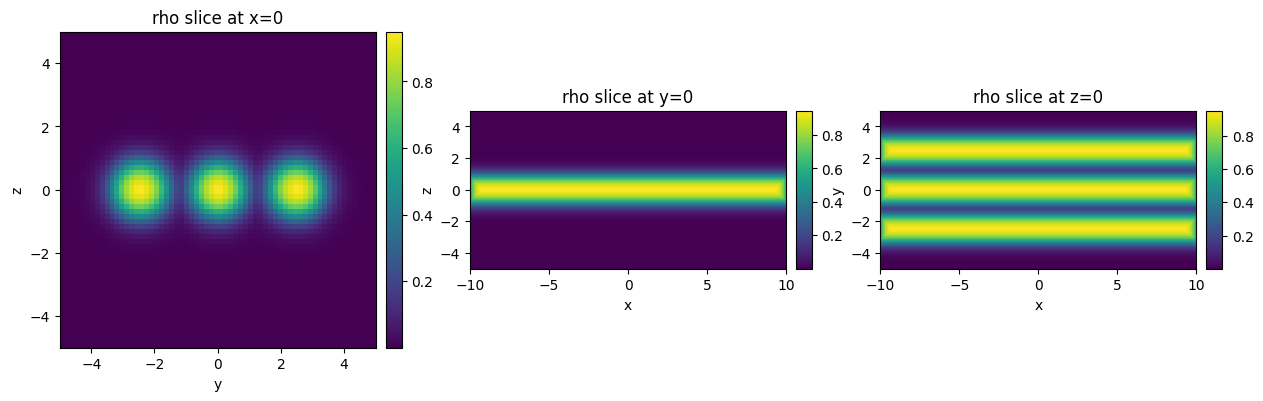

In [9]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho_scale = 4
rho_offset = 0.5
# plot the functions
sdfs = jnp.linspace(-5, 10)
rhos = sdf_to_rho(sdfs, scale=rho_scale, offset=rho_offset)

plt.plot(sdfs, rhos)

rho = sdf_to_rho(sdf, scale=rho_scale, offset=rho_offset)

plot_grid(rho, Lx, Ly, Lz, Nx, Ny, Nz, "rho")
print(f"rho min: {jnp.min(rho)}, rho max: {jnp.max(rho)}")

Sizing field min: 0.625, max: 2.5


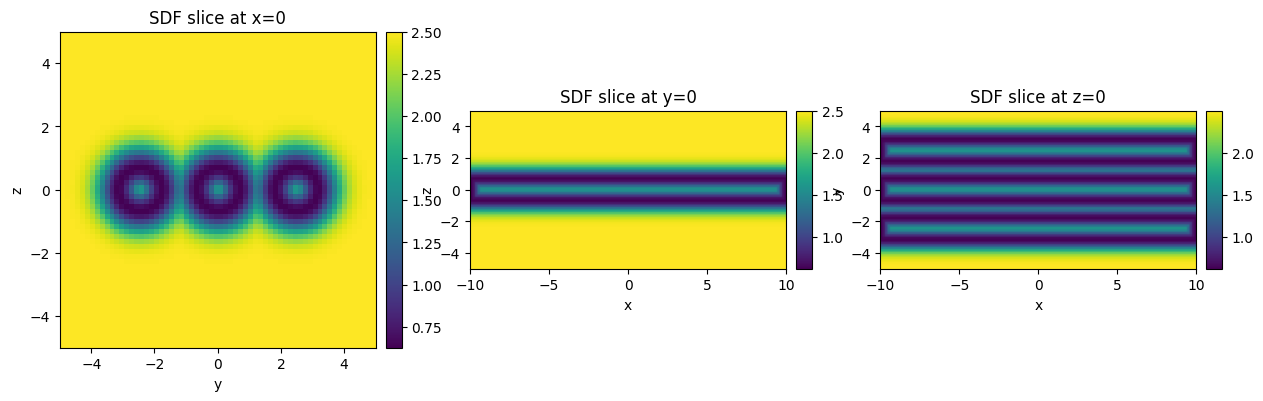

In [10]:
def sizing_field(
    sdf: jnp.ndarray, min_size: float = 0.1, max_size: float = 1.0, scale: float = 2.0
) -> jnp.ndarray:
    """Generate a sizing field from the signed distance function.

    The field is low (size = min_size) near the structure (sdf=0) and high (size = max_size) far from it.

    Args:
        sdf: Signed distance function values.
        min_size: Minimum element size near the structure.
        max_size: Maximum element size far from the structure.
        scale: Controls the transition steepness.

    Returns:
        Sizing field values.
    """

    def gauss(x: jnp.ndarray, mu: float, sigma: float) -> jnp.ndarray:
        return jnp.exp(-0.5 * ((x - mu) / sigma) ** 2)

    normalized_sdf = 1 - gauss(sdf, 0.0, 1.0 / scale)
    return min_size + (max_size - min_size) * normalized_sdf


sizing_min = Lx / 32
sizing_max = Lx / 8
sizing_scale = 2.0
sizing = sizing_field(sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale)
plot_grid(sizing, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"Sizing field min: {sizing.min()}, max: {sizing.max()}")

## Adpative Hex Meshing Tesseract

In [11]:
max_points = 30000
max_cells = 30000

mesher_out = apply_tesseract(
    hex_tess,
    {
        "domain_size": [Lx, Ly, Lz],
        "sizing_field": sizing,
        "field_values": rho,
        "max_subdivision_levels": 3,
        "max_points": max_points,
        "max_cells": max_cells,
    },
)
print(
    f"Mesh points: {mesher_out['mesh']['n_points']}, Mesh faces: {mesher_out['mesh']['n_faces']}"
)
pts = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]

hex_mesh = mesher_out["mesh"]

print(jnp.max(mesher_out["mesh_cell_values"]))
print(mesher_out["mesh_cell_values"].shape)

Mesh points: 10231, Mesh faces: 7952
0.91622925
(30000,)


We can look at the density values and the hex mesh cell center positions using a 3D scatter plot.

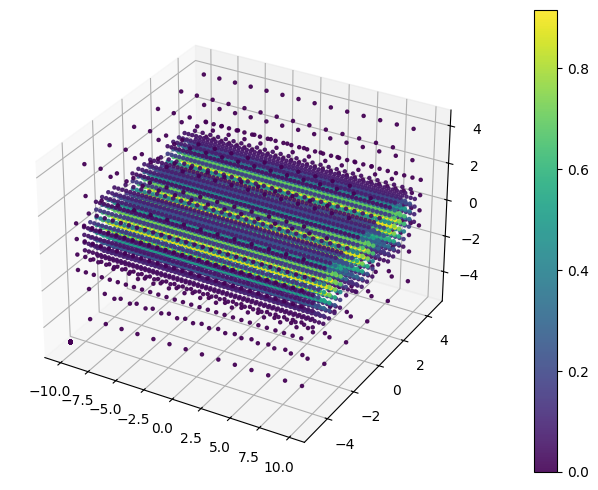

In [12]:
# lets make a scatter plot of the mesh cell values as colors
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={"projection": "3d"})
pts_coords = hex_mesh["points"]
hex_cells = hex_mesh["faces"]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)
rho_mesh = rho.flatten()
scat = ax.scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=mesher_out["mesh_cell_values"],
    s=5,
    alpha=0.9,
    cmap="viridis",
)
# colorbar
cbar = plt.colorbar(scat, ax=ax, pad=0.1)

## Boundary Conditions

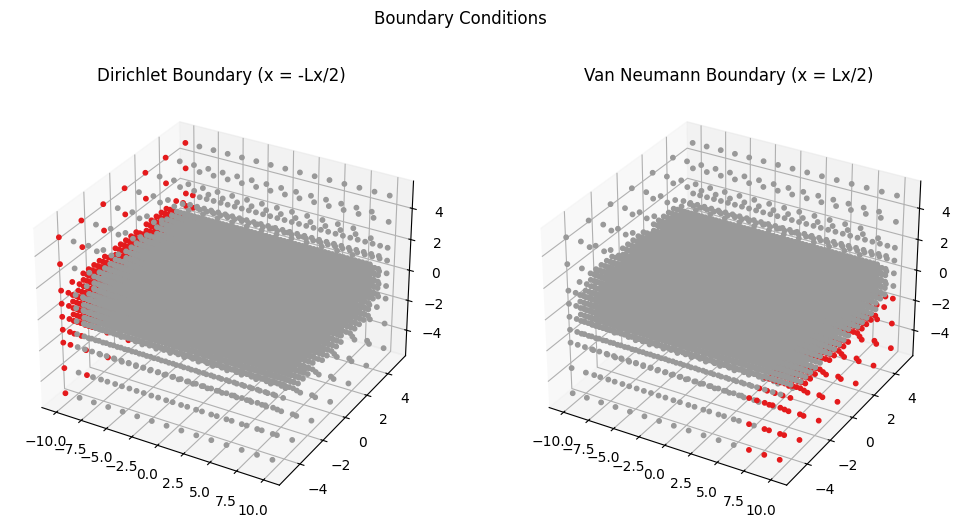

In [ ]:
# Lets setup the boundary conditions


def get_boundary_masks(
    mesh: dict, Lx: float, Lz: float
) -> tuple[jnp.ndarray, jnp.ndarray]:
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Lz: Size of the domain in z-direction.

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        von_neumannn_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = pts[:, 0] <= -Lx / 2 + Lx / 20
    von_neumann_mask = jnp.logical_and(
        jnp.isclose(pts[:, 0], Lx / 2, atol=Lz / 3),
        jnp.isclose(pts[:, 2], -Lz / 2, atol=Lz / 3),
    )

    return dirichlet_mask, von_neumann_mask


dirichlet_mask, von_neumann_mask = get_boundary_masks(hex_mesh, Lx, Lz)

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
# set the colormap to Set1
plt.suptitle("Boundary Conditions")
# remove the axis ticks
pts = hex_mesh["points"][: hex_mesh["n_points"]]

axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask[: hex_mesh["n_points"]], 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[0].set_title("Dirichlet Boundary (x = -Lx/2)")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(von_neumann_mask[: hex_mesh["n_points"]], 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[1].set_title("Van Neumann Boundary (x = Lx/2)")

# convert to int arrays for tesseract input
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
von_neumann_mask = von_neumann_mask.astype(jnp.int32)

## Finite Element Analysis

In [14]:
compliance = apply_tesseract(
    fem_tess,
    {
        "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
        "hex_mesh": hex_mesh,
        "dirichlet_mask": dirichlet_mask,
        "dirichlet_values": jnp.array([0.0]),
        "von_neumann_mask": von_neumann_mask,
        "von_neumann_values": jnp.array([[0.0, 0.0, 1.0]]) / jnp.sum(von_neumann_mask),
    },
)["compliance"]
print(f"Compliance: {compliance:.4f}")

Compliance: 0.1003


In [15]:
max_points = 15000
max_cells = 15000


def loss(
    params: jnp.ndarray,
    iteration: int = 0,
) -> tuple[float, dict]:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).
        iteration: current optim iteration.

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    # Generate signed distance field from design parameters
    # params = identity_and_store_grads(params, iteration + 0)
    design_out = apply_tesseract(
        design_tess,
        {"differentiable_parameters": params.flatten(), **design_inputs},
    )

    sdf = design_out["sdf"]

    # Convert SDF to material density distribution
    rho_grid = sdf_to_rho(sdf, scale=2)

    sizing = sizing_field(
        sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale
    )
    sizing = jax.lax.stop_gradient(sizing)

    mesher_out = apply_tesseract(
        hex_tess,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
            "field_values": rho_grid,
            "max_subdivision_levels": 2,
            "max_points": max_points,
            "max_cells": max_cells,
        },
    )

    rho_cell = jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1)

    mesh = stop_grads_int(mesher_out["mesh"])

    dirichlet_mask, von_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    von_neumann_mask = jax.lax.stop_gradient(von_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    von_neumann_values = jnp.array([[0.0, 0.0, 1.0]]) / jnp.sum(von_neumann_mask)

    c = apply_tesseract(
        fem_tess,
        {
            "rho": rho_cell,
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "von_neumann_mask": von_neumann_mask,
            "von_neumann_values": von_neumann_values,
        },
    )["compliance"]

    surface_mesh = {
        "points": design_out["mesh"]["points"][: design_out["mesh"]["n_points"]],
        "faces": design_out["mesh"]["faces"][: design_out["mesh"]["n_faces"]],
    }

    hex_mesh = {
        "points": mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]],
        "faces": mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]],
        "rho": mesher_out["mesh_cell_values"][: mesher_out["mesh"]["n_faces"]],
    }

    return c, {
        "sdf": sdf,
        "rho_grid": rho_grid,
        "sizing": sizing,
        "hex_mesh": hex_mesh,
        "surface_mesh": surface_mesh,
    }


grad_fn = jax.value_and_grad(loss, has_aux=True)

In [17]:
def optimize(
    diffable_params: jnp.ndarray,
    iterations: int = 20,
) -> tuple[list, list, list]:
    """Optimize a design defined by parameters."""
    params = diffable_params.copy()
    loss_hist = []
    params_hist = []
    aux_hist = []

    optmizer = optax.adam(learning_rate=0.02)
    opt_state = optmizer.init(params)

    for i in range(iterations):
        (loss_value, aux), grads = grad_fn(params, iteration=i)

        grads = grads / jnp.max(grads)
        updates, opt_state = optmizer.update(
            grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
        )
        params = optax.apply_updates(params, updates)
        params = params.at[::3].set(initial_params.at[::3].get())

        loss_hist.append(loss_value)
        params_hist.append(params)
        aux_hist.append(aux)

        print(f"Iteration {i + 1}, Loss: {loss_value:.4f}")

    return loss_hist, params_hist, aux_hist

We can now run an optmization on the ranomly initialized geometry. The main bottleneck of this pipeline is the SDF compuations which has signifcant overhead slowing this optimization down. Exeucting this cell can take up to an hour.

In [18]:
loss_hist, params_hist, aux_hist = optimize(initial_params, iterations=16)

Iteration 1, Loss: 0.3303
Iteration 2, Loss: 0.3271
Iteration 3, Loss: 0.2051
Iteration 4, Loss: 0.1626
Iteration 5, Loss: 0.1593
Iteration 6, Loss: 0.1519
Iteration 7, Loss: 0.1390
Iteration 8, Loss: 0.1253
Iteration 9, Loss: 0.1112
Iteration 10, Loss: 0.0982
Iteration 11, Loss: 0.0869
Iteration 12, Loss: 0.0773
Iteration 13, Loss: 0.0689
Iteration 14, Loss: 0.0614
Iteration 15, Loss: 0.0556
Iteration 16, Loss: 0.0508


Text(0.5, 1.0, 'Compliance over Optimization')

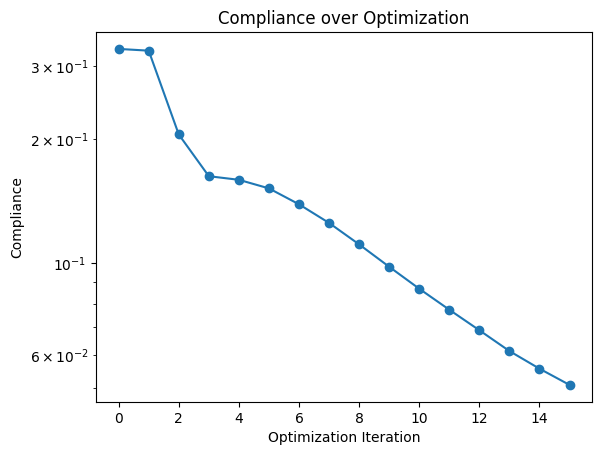

In [19]:
plt.plot(loss_hist, marker="o")
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization")

### Optimization Postprocess

In order to visualize the optmization, we generate a gif showing the evolution of the surface mesh.

In [20]:
# lets visualize the 3d meshes over the optimization
for i, aux in enumerate(aux_hist):
    plot_mesh(
        aux["surface_mesh"],
        save_path=f"tmp_img/mesh_optim_{i:03d}.png",
        bounds=[Lx, Ly, Lz],
    )

images = []

for i in range(len(aux_hist)):
    filename = f"tmp_img/mesh_optim_{i:03d}.png"
    images.append(imageio.imread(filename))
    print(f"Added {filename} to gif.")
# make sure the gif repeats forever
imageio.mimsave("imgs/mesh_optim.gif", images, fps=10, loop=0)

/tmp/ipykernel_71070/1108791225.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


Added tmp_img/mesh_optim_000.png to gif.
Added tmp_img/mesh_optim_001.png to gif.
Added tmp_img/mesh_optim_002.png to gif.
Added tmp_img/mesh_optim_003.png to gif.
Added tmp_img/mesh_optim_004.png to gif.
Added tmp_img/mesh_optim_005.png to gif.
Added tmp_img/mesh_optim_006.png to gif.
Added tmp_img/mesh_optim_007.png to gif.
Added tmp_img/mesh_optim_008.png to gif.
Added tmp_img/mesh_optim_009.png to gif.
Added tmp_img/mesh_optim_010.png to gif.
Added tmp_img/mesh_optim_011.png to gif.
Added tmp_img/mesh_optim_012.png to gif.
Added tmp_img/mesh_optim_013.png to gif.
Added tmp_img/mesh_optim_014.png to gif.
Added tmp_img/mesh_optim_015.png to gif.


![Workflow](imgs/mesh_optim.gif)